# MS Calculations

Notebook to crunch numbers for the MS.

by Cascade Tuholske 2020.02.23 

Updated 2020.08.27 - CPT
Was run on ERA5 RH with CHIRTS-Daily Tmax from ERA5

In [2]:
#### Depdencies 
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

In [2]:
#### Regressions, no intercept addition is needed because we're using SK LEARN HERE 

def lm_func(df, col):
    
    "simple linear model of a time series data, returns coef"
    
    # Get Data
    X_year = np.array(df.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
    Y_stats = np.array(df.groupby('year')[col].sum()).reshape((-1, 1))

    # Add Intercept
    X_year_2 = sm.add_constant(X_year)

    # Regress
    model = sm.OLS(Y_stats, X_year_2).fit() 
        
    coef = int(model.params[1])
    #coef = int(coef)
            
    # R2 and P
    r2 = model.rsquared_adj
    p = model.pvalues[0]
    
    return coef, round(r2, 2), round(p, 3)

In [3]:
#### Load Data

# file paths
DATA_IN = "/home/cascade/projects/UrbanHeat/data/"  # Note: Need ?dl=1 to make sure this file gets read correctly
FIG_OUT = "/home/cascade/projects/UrbanHeat/figures/"
FN_IN = 'processed/AllDATA-GHS-ERA5-HI406-FIGDATA.csv'
HI_STATS = pd.read_csv(DATA_IN+FN_IN)

# Set scale
scale = 10**9

# STATS IN
HI_STATS = pd.read_csv(DATA_IN+FN_IN)

# GHS-UCDB IN
GHS_FN = 'raw/GHS_UCDB/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_0.shp'
GHS = gpd.read_file(DATA_IN+GHS_FN)
print('Len of GHS-UCDB (all cities) is', len(GHS))

# Check it
HI_STATS.head()

Len of GHS-UCDB (all cities) is 13135


,Unnamed: 0,ID_HDC_G0,year,total_days,P,P1983,P2016,people_days,people_days_heat,people_days_pop
0,0,3091,1983,1,53715.040735,53715.040735,58301.880371,53715.040735,53715.040735,0.000000
1,1,3091,1984,2,54204.006604,53715.040735,58301.880371,108408.013208,107430.081470,977.931738
2,2,3091,1985,2,54692.972473,53715.040735,58301.880371,109385.944946,107430.081470,1955.863477
3,3,3091,1986,2,55181.938342,53715.040735,58301.880371,110363.876685,107430.081470,2933.795215
4,4,3091,1988,1,56159.870081,53715.040735,58301.880371,56159.870081,53715.040735,2444.829346


In [4]:
# Drop cites where 1983 had 1 day and none elsewhere

print(len(HI_STATS))
only83 = HI_STATS.groupby('ID_HDC_G0')['total_days'].sum() == 1 # sum up total days and find those with 1 day
only83 = list(only83[only83 == True].index) # make a list of IDs
sub = HI_STATS[HI_STATS['ID_HDC_G0'].isin(only83)] # subset those IDs
bad_ids = sub[(sub['year'] == 1983) & (sub['total_days'] == 1)] # drop those from 1983 only
drop_list = list(bad_ids['ID_HDC_G0']) # make a list
HI_STATS= HI_STATS[~HI_STATS['ID_HDC_G0'].isin(drop_list)] # drop those from the list
print(len(HI_STATS))

391816
390524
390422


In [5]:
## Add In Meta Data
geog = ['region', 'intermediate-region', 'sub-region','CTR_MN_NM', 'ID_HDC_G0', 'GCPNT_LAT', 'GCPNT_LON']
meta_fn = 'processed/AllDATA-GHS-ERA5-HI406-META.csv'
ALL_DATA = pd.read_csv(DATA_IN+meta_fn)
META = ALL_DATA[geog]
META = META.drop_duplicates('ID_HDC_G0')

## Merge in meta
HI_STATS= HI_STATS.merge(META, on = 'ID_HDC_G0', how = 'left')
HI_STATS.head()


,Unnamed: 0,ID_HDC_G0,year,total_days,P,P1983,P2016,people_days,people_days_heat,people_days_pop,region,intermediate-region,sub-region,CTR_MN_NM,GCPNT_LAT,GCPNT_LON
0,0,3091,1983,1,53715.040735,53715.040735,58301.880371,53715.040735,53715.040735,0.000000,Europe,Eastern Europe,Eastern Europe,Poland,54.088065,18.783016
1,1,3091,1984,2,54204.006604,53715.040735,58301.880371,108408.013208,107430.081470,977.931738,Europe,Eastern Europe,Eastern Europe,Poland,54.088065,18.783016
2,2,3091,1985,2,54692.972473,53715.040735,58301.880371,109385.944946,107430.081470,1955.863477,Europe,Eastern Europe,Eastern Europe,Poland,54.088065,18.783016
3,3,3091,1986,2,55181.938342,53715.040735,58301.880371,110363.876685,107430.081470,2933.795215,Europe,Eastern Europe,Eastern Europe,Poland,54.088065,18.783016
4,4,3091,1988,1,56159.870081,53715.040735,58301.880371,56159.870081,53715.040735,2444.829346,Europe,Eastern Europe,Eastern Europe,Poland,54.088065,18.783016


# Global Trends

In [39]:
#### Total Change in people Days
data = HI_STATS.groupby('year')['people_days'].sum()
year = str(data.index[33])
value = str(data.values[33]/10**9)
print('person days in 2016 was '+value+' billion')

year = str(data.index[0])
value = str(data.values[0]/10**9)
print('person days in 1983 was '+value+' billion')

#### Pct Change in Poeple Days 1983 - 2016
pdays16 = data.iloc[len(data) -1]
pdays83 = data.iloc[0]
out = (data.iloc[len(data) -1] - data.iloc[0]) / data.iloc[0] * 100
print('pct increase in people days 83 - 16 is ', out)


person days in 2016 was 341.57487509305133 billion
person days in 1983 was 148.15391211226938 billion
pct increase in people days 83 - 16 is  130.5540705764217


In [45]:
#### Rate of change
data = HI_STATS
coef, r2, p = lm_func(data, 'people_days')
print('annual increase in people days ', 'was', coef/10**9, ' p=', p)
coef1, r21, p1 = lm_func(data, 'people_days_heat')
print('annual increase in people days heat ', 'was', coef1/10**9, ' p=', p)
coef2, r22, p2 = lm_func(data, 'people_days_pop')
print('annual increase in people days pop ', 'was', coef2/10**9, ' p=', p)
print('attrib heat ', 'was', coef1 / coef *100, ' p=', p, '\n')

annual increase in people days  was 5.593848435  p= 0.0
annual increase in people days heat  was 1.137149775  p= 0.0
annual increase in people days pop  was 4.456698659  p= 0.0
attrib heat  was 20.32857679670043  p= 0.0 



In [7]:
#### Pct Pday Annual Increase from Heat
coef_pdays, r2_pdays, p_pdays = lm_func(HI_STATS, 'people_days') # regress pdays
coef_heat, r2_heat, p_heat = lm_func(HI_STATS, 'people_days_heat') # regreas heat

print('warming is what pct of total?', coef_heat/coef_pdays *100)

warming is what pct of total? 20.32857679670043


# City-level

#### Pdays

In [50]:
city_coefs = pd.read_csv(DATA_IN+'processed/AllDATA-GHS-ERA5-HI406-MAPDATA_PDAYS_P05.csv')

In [9]:
len(city_coefs)

7931

In [51]:
#### Number of cities w/ sig increase in exposure?
print('The pct of cities w/ increases in exposure: ', len(city_coefs)/len(GHS)*100)


The pct of cities w/ increases in exposure:  60.38066235249334


In [142]:
city_coefs.columns

Index(['Unnamed: 0', 'ID_HDC_G0', 'coef_pdays', 'p_value_pdays', 'coef_heat',
       'p_value_heat', 'coef_pop', 'p_value_pop', 'coef_totDays',
       'p_value_totDays', 'coef_attrib', 'coef_attrib_norm', 'region',
       'intermediate-region', 'sub-region', 'CTR_MN_NM', 'GCPNT_LAT',
       'GCPNT_LON', 'P1983', 'P2016'],
      dtype='object')

In [147]:
len(city_coefs)

7931

In [150]:
ans = len(city_coefs[(city_coefs['GCPNT_LAT'] < 23.5) & (city_coefs['GCPNT_LAT'] > -23.5)]) / len(city_coefs)
print('what pct of pday cities are low lat?', ans*100)

what pct of pday cities are low lat? 52.96936073635102


In [64]:
def country_search(country, data_set):
    "what pct of cities had a p-day increase?"
    print('Num of Cities in '+country+' ', len(data_set[data_set['CTR_MN_NM'] == country]) / len(GHS[GHS['CTR_MN_NM'] == country]) *100)

In [65]:
data_set = city_coefs

In [66]:
country_search('Senegal', data_set)

Num of Cities in Senegal  96.96969696969697


In [67]:
country_search('Nigeria', data_set)

Num of Cities in Nigeria  97.9296066252588


In [68]:
country_search('India', data_set)

Num of Cities in India  89.28571428571429


#### Total Heat Days 

In [69]:
city_totdays = pd.read_csv(DATA_IN+'processed/AllDATA-GHS-ERA5-HI406-MAPDATA_TOTDAYS_P05.csv')

In [73]:
print('What pct of all cities had sig increase in days/yr > 40.6 C Hi?')
print(len(city_totdays)/len(GHS))
print(len(city_totdays))

What pct of all cities had sig increase in days/yr > 40.6 C Hi?
0.503083365055196
6608


In [82]:
print('What pct of all cities >1 day / yr in days/yr > 40.6 C Hi?')
print(len(city_totdays[city_totdays['coef_totDays'] >= 1])/len(GHS))
print(len(city_totdays[city_totdays['coef_totDays'] >= 1]))

What pct of all cities >1 day / yr in days/yr > 40.6 C Hi?
0.2879330034259612
3782


In [80]:
## How many cities day increase per year ... 1, 3
top = len(city_totdays)
bottom = len(city_totdays[city_totdays['coef_totDays'] >= 2])

In [81]:
print(top)
print(bottom)

6608
336


In [83]:
#### Columbo & San Salvador & Conakry
print('Conakry tot days:', city_totdays[city_totdays['ID_HDC_G0'] == 1502]['coef_totDays'].values)
print('columbo tot days:', city_totdays[city_totdays['ID_HDC_G0'] == 8835]['coef_totDays'].values)
print('San Sal tot days:', city_totdays[city_totdays['ID_HDC_G0'] == 321]['coef_totDays'].values)

Conakry tot days: [3.28006112]
columbo tot days: [2.69793736]
San Sal tot days: [1.44125286]


# Regional Trends

In [26]:
#### Annual Rates

scale = 10**6
geog = 'sub-region'

for label in np.unique(HI_STATS[geog]):
    label = label
    data = HI_STATS[HI_STATS[geog] == label]
    
    #### Rate of change
    coef, r2, p = lm_func(data, 'people_days')
    print('annual increase in people days '+label, 'was', coef/scale, ' p=', p)
    coef1, r21, p1 = lm_func(data, 'people_days_heat')
    print('annual increase in people days heat '+label, 'was', coef1/scale, ' p=', p)
    coef2, r22, p2 = lm_func(data, 'people_days_pop')
    print('annual increase in people days pop '+label, 'was', coef2/scale, ' p=', p)
    print('attrib heat '+label, 'was', coef1 / coef *100, ' p=', p, '\n')
  

annual increase in people days Australia and New Zealand was 1.688044  p= 0.0
annual increase in people days heat Australia and New Zealand was 0.719555  p= 0.0
annual increase in people days pop Australia and New Zealand was 0.968488  p= 0.0
attrib heat Australia and New Zealand was 42.626554758051334  p= 0.0 

annual increase in people days Central Asia was 3.478678  p= 0.001
annual increase in people days heat Central Asia was 0.450853  p= 0.001
annual increase in people days pop Central Asia was 3.027825  p= 0.001
attrib heat Central Asia was 12.960469465699326  p= 0.001 

annual increase in people days Eastern Asia was 352.915916  p= 0.0
annual increase in people days heat Eastern Asia was 53.17979  p= 0.0
annual increase in people days pop Eastern Asia was 299.736125  p= 0.0
attrib heat Eastern Asia was 15.068685652590402  p= 0.0 

annual increase in people days Eastern Europe was 7.342326  p= 0.013
annual increase in people days heat Eastern Europe was 7.118085  p= 0.013
annual 

In [27]:
#### Trends for Africa, N & SS
geog = 'region'
location = 'Africa'
data = HI_STATS[HI_STATS[geog] == location]
print(location)

#### Total Change in people Days
data = data.groupby('year')['people_days'].sum()
year = str(data.index[33])
value = str(data.values[33]/10**9)
print('person days in 2016 was '+value+' billion')

year = str(data.index[0])
value = str(data.values[0]/10**9)
print('person days in 1983 was '+value+' billion')

#### Pct Change in Poeple Days 1983 - 2016
pdays16 = data.iloc[len(data) -1]
pdays83 = data.iloc[0]
out = (data.iloc[len(data) -1] - data.iloc[0]) / data.iloc[0] * 100
print('pct increase in people days 83 - 16 is ', out)



Africa
person days in 2016 was 56.29063764754387 billion
person days in 1983 was 17.243777343461907 billion
pct increase in people days 83 - 16 is  226.44029510672635


In [28]:
#### S Asia as pct of total  global = 5.245146271 B 

print('pct of total pdays from S Asia is ', 1899.70765 / 10**3 / 5.245146271 * 100)

pct of total pdays from S Asia is  36.218392240142734


In [29]:
#### Median Slope
region = 'Europe'
col = 'coef_heat'
geog = 'region'
scale = 10**3
result = city_coefs[city_coefs[geog]== region][col].median()
print(region, col, 'is ', result/scale)

Europe coef_heat is  11.300829250493686


# Trend First vs. Second Half of Data

In [30]:
data.head()

year
1983    1.724378e+10
1984    1.783957e+10
1985    1.720283e+10
1986    1.918034e+10
1987    2.332944e+10
Name: people_days, dtype: float64

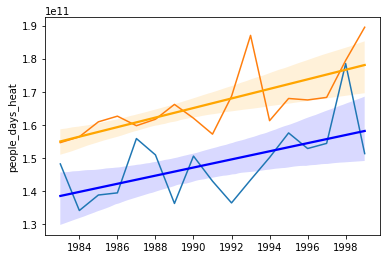

In [31]:
#### Share of exposure due to heat by 17 year split

## 1983 - 1999
data1 = HI_STATS[(HI_STATS['year'] >= 1983) & (HI_STATS['year'] < 2000)]
coef1pop , r21pop, p1pop  = lm_func(data1 , 'people_days_pop')
coef1heat , r21heat, p1heat = lm_func(data1 , 'people_days_heat')

years = list(np.unique(data1['year']))
plt.plot(years, data1.groupby('year')['people_days_heat'].sum())
sns.regplot(years, data1.groupby('year')['people_days_heat'].sum(), 
            color = 'blue', scatter = False, truncate = True)

## 2000 - 2016
data2 = HI_STATS[(HI_STATS['year'] >= 2000) & (HI_STATS['year'] <= 2016)]
coef2heat , r22heat, p2heat = lm_func(data2 , 'people_days_heat')
coef2pop , r22pop, p1pop  = lm_func(data2 , 'people_days_pop')

years = list(np.unique(data1['year']))
plt.plot(years, data2.groupby('year')['people_days_heat'].sum())
sns.regplot(years, data2.groupby('year')['people_days_heat'].sum(), 
            color = 'orange', scatter = False, truncate = True)

In [32]:
## 2000 - 2016
data2pop = HI_STATS[(HI_STATS['year'] >= 1983) & (HI_STATS['year'] < 2000)]
coef2pop , r22pop, p1pop  = lm_func(data2pop , 'people_days_pop')

data2heat = HI_STATS[(HI_STATS['year'] >= 2000) & (HI_STATS['year'] <= 2016)]
coef2heat , r22heat, p2heat = lm_func(data2heat , 'people_days_heat')


In [33]:
## Estimates
print('From 83 - 99, contribution from heat was', coef1heat/(coef1pop+coef1heat))
print('From 00 - 16, contribution from heat was', coef2heat/(coef2pop+coef2heat))
print('From 83 - 00, heat was', coef1heat/10**9, round(p1heat, 3))
print('From 00 - 16, heat was', coef2heat/10**9)
print('From 83 - 00, pop was', coef1pop/10**9)
print('From 00 - 16, pop was', coef2pop/10**9)

From 83 - 99, contribution from heat was 0.22974344669325134
From 00 - 16, contribution from heat was 0.2597042523722036
From 83 - 00, heat was 1.228103981 0.021
From 00 - 16, heat was 1.444445682
From 83 - 00, pop was 4.117441229
From 00 - 16, pop was 4.117441229


# Heat Waves

- 9691 Kolkata 1998
- 2046 Paris 2003
- 4417, Aleppo 2010

In [ ]:
# Find Heat Wave From All DATA
def select_city_year(df, city_id, year):
    "Quick search to find city and years within HI_STATS"
    df_out = df[(df['ID_HDC_G0'] == city_id) & (df['year'] == year)]
    
    return df_out

meta_fn = '/home/cascade/projects/UrbanHeat/data/processed/AllDATA-GHS-ERA5-HI406-META.csv'
ALL_DATA = pd.read_csv(meta_fn)

# [4417, 'Aleppo'] [2046, 'Paris'] [9691, 'Kolkata'] 
city = select_city_year(ALL_DATA, 4417, 2010)
city

In [ ]:
# Make a def
df = pd.DataFrame()
df = df.append(means, ignore_index=True)
df = df.append(hi_year, ignore_index=True)
df.columns = cols
df

In [13]:
# Isloate daily HI vs averages 
# Kolkata df.iloc[:,54:72]
# Paris df.iloc[:,125:125+9] 
# Aleppo df.iloc[:,92 :145]
wave = df.iloc[:,92 :145]
wave = wave.transpose()
wave.columns = ['mean', 'HI']
wave['hi_dif'] = wave['HI'] - wave['mean'] 
# wave['>50'] = wave['HI'] - 50
print(wave['hi_dif'].mean())
wave

NameError: name 'df' is not defined

# Check out cities

In [34]:
def select_city_year(df, city_id, year):
    "Quick search to find city and years within HI_STATS"
    df_out = df[(df['ID_HDC_G0'] == city_id) & (df['year'] == year)]
    
    return df_out


In [35]:
city = select_city_year(ALL_DATA, 4417, 2010)
city

# LA

In [92]:
from glob import glob 
import os

In [97]:
dir_list = '/home/cascade/projects/UrbanHeat/data/interim/ERA5_HI/'


In [107]:
fn = 'GHS-ERA5-HI_2009.csv'
data = pd.read_csv(dir_list+fn)
city = data[data['ID_HDC_G0'] == 14]

In [135]:
temps_list = []
dates_list = []
for fn in sorted(os.listdir(dir_list)):
    data = pd.read_csv(dir_list+fn)
    city = data[data['ID_HDC_G0'] == 14]
    dates = list(city.iloc[:,3:])
    temps = list(city.iloc[:,3:].values[0])
    dates_list.extend(dates)
    temps_list.extend(temps)

In [137]:
len(dates_list)

12419